In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://raw.githubusercontent.com/MATF-istrazivanje-podataka-1/2023_Data_Mining_Chess_Dataset/main/Preprocessing/preprocessed_set.csv')

In [ ]:
data.head()
data.drop(columns=['Unnamed: 0'],inplace=True)
indexes=data[data['winner']==0].index
##################### OVO OBRISI. OVO JE BRISANJE REMIJA ########################
# data.drop(indexes,inplace=True)
#########################################################

In [ ]:
data.head()

# Klasifikacija

Zelimo da postupkom kalsifikacije na osnovu podataka iz tabele predvidimo da li je pobedio crni ili beli. U skupu nema neresenih

<BarContainer object of 2 artists>

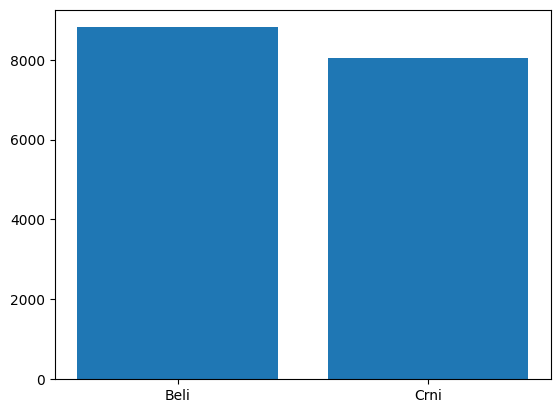

In [ ]:
data['winner'].replace([1,2],[1,0],inplace=True)

d=data.winner.value_counts()
plt.bar(["Beli","Crni"],[d.iloc[0],d.iloc[1]])

In [ ]:
len(data)

16865

Klase su balansirane u odnosu 52-48% u korist belog i zato nece biti potrebe za uzorkovanjem

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

##Konverzija otvaranja (ovo prebaciti u preprocesiranje)

In [ ]:
otvaranja=data['opening_eco']
def convert_op_eco(s):
  s=s.strip()
  return (ord(s[0])-ord('A')+1)*100+int(s[1]+s[2])
otvaranja
print(convert_op_eco('Z20'))
otv_int=list(map(convert_op_eco,otvaranja))
data['opening_eco']=otv_int
data.head()

2620


,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,increment_code
0,1,16,2,2,1322,1261,200,4,2
1,1,61,3,1,1439,1454,402,3,2
2,1,95,3,1,1523,1469,341,5,3
4,1,33,2,1,1520,1423,400,10,2
5,0,9,2,2,1413,2108,200,5,3


##Podela na ulazne i ciljne atribute:

In [ ]:
Y = data['winner']
X = data.drop(columns=['winner'])
feature_names = X.columns
X.shape
Y.value_counts()

1    8812
0    8053
Name: winner, dtype: int64

##Podela na test i trening skupove:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [ ]:
def report(y_real, y_pred):
    print('Confusion matrix:')
    print(confusion_matrix(y_real, y_pred))
    print('Accuracy score:')
    print(accuracy_score(y_real, y_pred))
    print('Precision score: ')
    print(precision_score(y_real, y_pred))
    print('Recall score: ')
    print(recall_score(y_real, y_pred))
def new_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    print('Train data:\n')
    y_train_pred = model.predict(X_train)
    report(y_train, y_train_pred)
    
    print('\n--------------------------------------\n')

    print('Test data:\n')
    y_pred = model.predict(X_test)
    report(y_test, y_pred)

    return model

In [ ]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=55)
dtc = new_model(dtc, X_train, X_test, Y_train, Y_test)
#error zbog otvaranja

Train data:

Confusion matrix:
[[6029    0]
 [   0 6619]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1190  834]
 [ 812 1381]]
Accuracy score:
0.6096751244960873
Precision score: 
0.6234762979683973
Recall score: 
0.6297309621523027


Pokusano je i sa modelima gde je velicina test skupa 20% i 30% velicine originalnog skupa. Ova podela nam daje najbolje rezultate

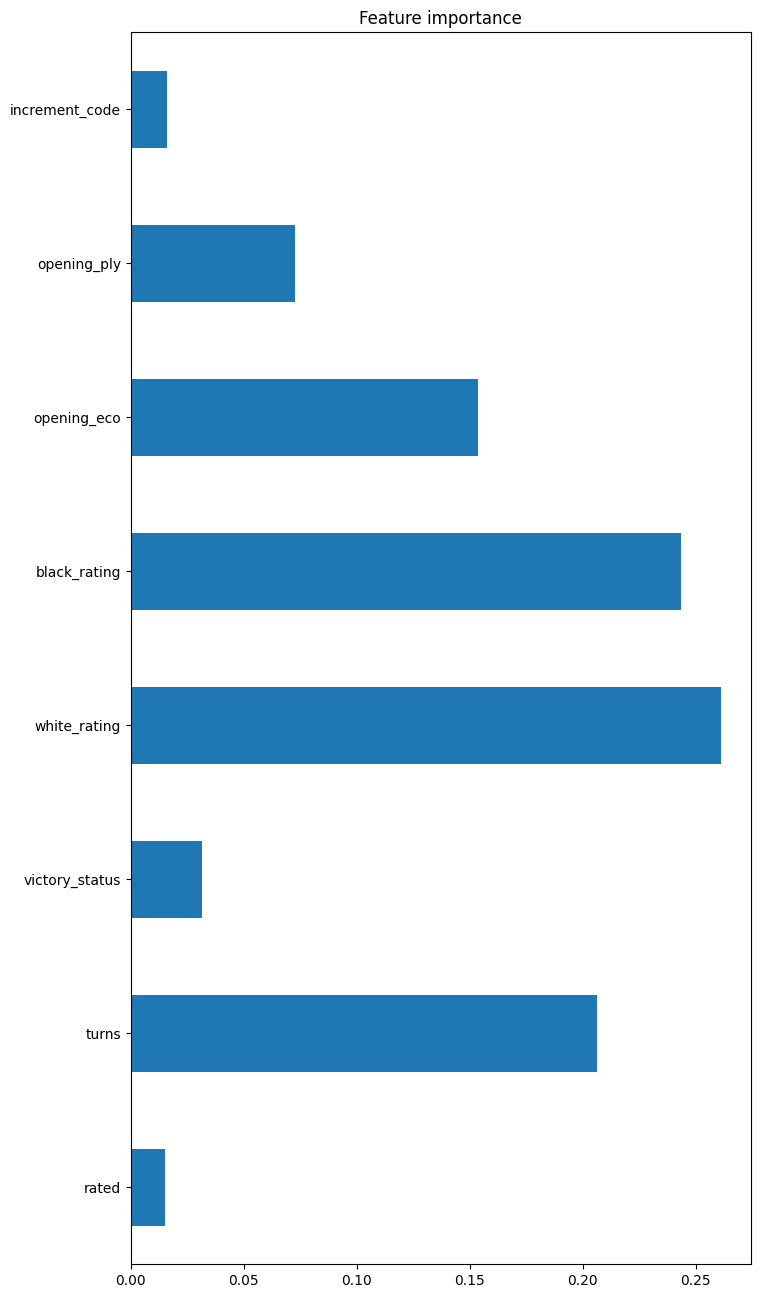

In [ ]:
plt.figure(figsize=(8, 16))
pd.Series(dtc.feature_importances_, index=X_train.columns).plot.barh()
plt.title("Feature importance")
plt.show()

Ovaj model je dosta neprecizan. Pokusacemo da poboljsamo model podesavanjem hiperparametara pomocu unakrsne validacije

#GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6, 8]
         }
estimator = GridSearchCV(DecisionTreeClassifier(random_state=55), param_grid=params, cv=3)
estimator.fit(X_train, Y_train)
estimator.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [ ]:
estimator.best_score_

0.6355154965211892

In [ ]:
estimator=new_model(estimator,X_train, X_test, Y_train, Y_test)

Train data:

Confusion matrix:
[[3310 2719]
 [1716 4903]]
Accuracy score:
0.6493516761543326
Precision score: 
0.6432694830753083
Recall score: 
0.7407463363045778

--------------------------------------

Test data:

Confusion matrix:
[[1077  947]
 [ 598 1595]]
Accuracy score:
0.6336258003319896
Precision score: 
0.6274586939417781
Recall score: 
0.7273141814865481


#Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=2)
random_forest.fit(X_train, Y_train)
random_forest = new_model(random_forest, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[5844  185]
 [1720 4899]]
Accuracy score:
0.8493833017077799
Precision score: 
0.9636113296616837
Recall score: 
0.7401420154101828

--------------------------------------

Test data:

Confusion matrix:
[[1585  439]
 [1318  875]]
Accuracy score:
0.5833530946170263
Precision score: 
0.6659056316590564
Recall score: 
0.3989968080255358


Slucajna suma sa 50 stabala

In [ ]:
random_forest_50_trees = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest_50_trees.fit(X_train, Y_train)
random_forest_50_trees = new_model(random_forest_50_trees, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[6029    0]
 [   0 6619]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1315  709]
 [ 700 1493]]
Accuracy score:
0.6658762153189471
Precision score: 
0.6780199818346957
Recall score: 
0.6808025535795713


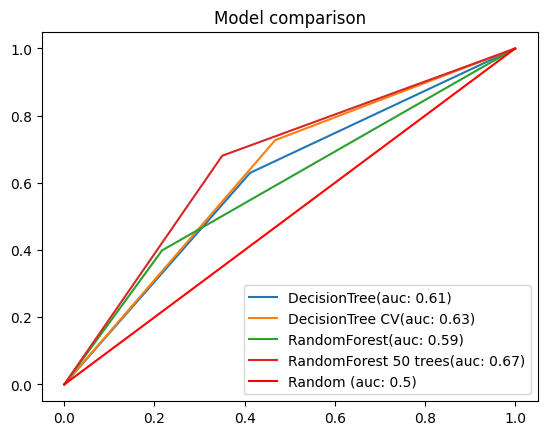

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc, estimator.best_estimator_, random_forest,random_forest_50_trees]
model_names = ['DecisionTree', 'DecisionTree CV',  'RandomForest', 'RandomForest 50 trees']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()


In [ ]:
modeli=[dtc,estimator.best_estimator_,random_forest,random_forest_50_trees]

In [ ]:
from joblib import dump
dump(modeli, 'decision_trees_modeli.joblib')

['decision_trees_modeli.joblib']

In [ ]:
import os
print(os.getcwd())
#ovde su je moj joblib fajl


/content
